# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jméno a login autora_

David Mihola, xmihol00

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [24]:
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    file = f.read().decode("utf-8")
    file = file.splitlines()[:3]
    data["conf"] = file[0].split(": ")[-1]
    data["run"] = int(file[1].split(": ")[-1])
    data["time"] = float(file[2].split(": ")[-1])
        
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

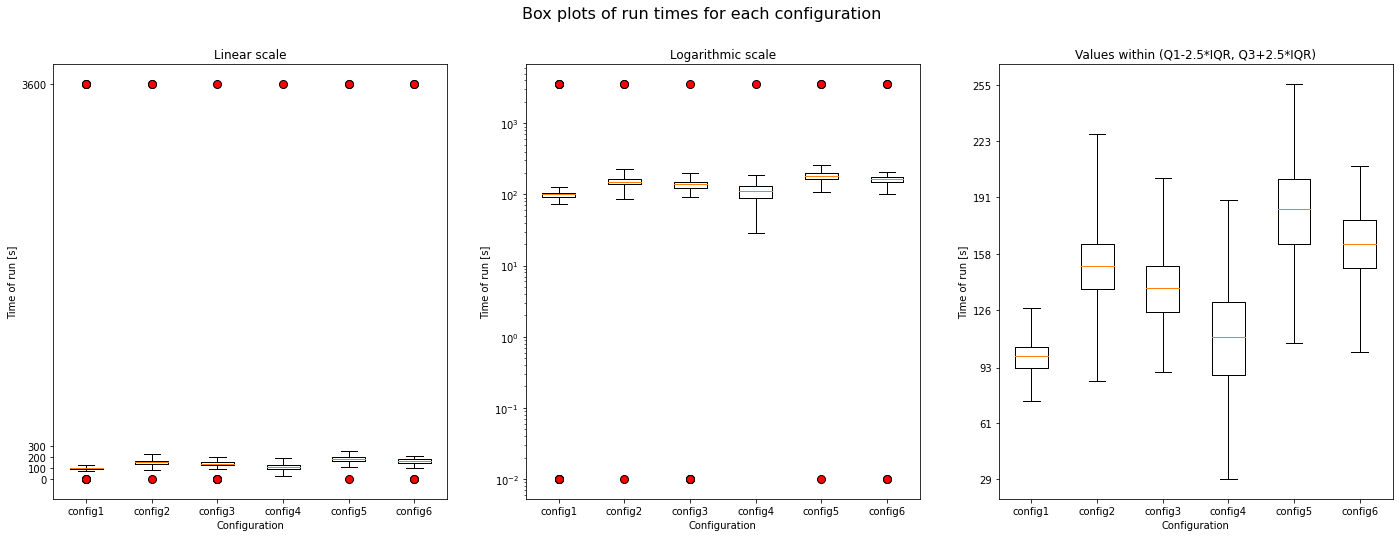

In [25]:
# Identification of outliers by visual inspection using box plots with custom whiskers position.
grouped_df = df.groupby("conf")
grouped_times = [ group["time"].tolist() for _, group in grouped_df ]

whis = 2.5 # 2.5 is better than 1.5 for this dataset
percentile_25, percentile_75 = np.percentile(grouped_times, [25, 75], axis=1)
IQR = percentile_75 - percentile_25
valid_indices = np.logical_and(grouped_times > (percentile_25 - whis * IQR)[:, np.newaxis], grouped_times < (percentile_75 + whis * IQR)[:, np.newaxis])
grouped_times_cleaned = [ group[valid_indices[i]] for i, group in enumerate(np.array(grouped_times)) ] # remove values outside of (Q1-2.5*IQR, Q3+2.5*IQR)

figure, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 8))
figure.suptitle("Box plots of run times for each configuration", fontsize=16)

ax0.boxplot(grouped_times, labels=grouped_df.groups.keys(), showfliers=True, flierprops=dict(marker="o", markerfacecolor="red", markersize=8), whis=whis)
ax0.set_yticks([0, 100, 200, 300, 3600])
ax0.set_xlabel("Configuration")
ax0.set_ylabel("Time of run [s]") # [s] deduced from the fact that some of the outliers are at 3600, which corresponds to 1 hour
ax0.set_title("Linear scale")

ax1.boxplot(grouped_times, labels=grouped_df.groups.keys(), showfliers=True, flierprops=dict(marker="o", markerfacecolor="red", markersize=8), whis=whis)
ax1.set_xlabel("Configuration")
ax1.set_ylabel("Time of run [s]")
ax1.set_yscale("log")
ax1.set_title("Logarithmic scale")

# configurations without outliers to get a better idea of the data distributions in each configuration
ax2.boxplot(grouped_times_cleaned, labels=grouped_df.groups.keys(), showfliers=True, flierprops=dict(marker="o", markerfacecolor="red", markersize=8), whis=whis)
# display the yticks so that they contain the minimum and maximum values of the cleaned data
ax2.set_yticks(np.linspace(np.min([np.min(config) for config in grouped_times_cleaned]), np.max([np.max(config) for config in grouped_times_cleaned]), 8, dtype=int))
ax2.set_xlabel("Configuration")
ax2.set_ylabel("Time of run [s]")
ax2.set_title("Values within (Q1-2.5*IQR, Q3+2.5*IQR)")

plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_  

Ano, objevily se 2 skupiny chybných hodnot:
* hodnoty blízko 0, u kterých bychom mohli usoudit, že algoritmus nebyl vůbec spuštěn, např. z důvodu nevalidních vstupních hodnot,
* hodnoty rovné 3600, u kterých bychom mohli usoudit, že běh algoritmu byl pozastaven po 1 hodině (3600 s), např. z důvodu neexistence výsledku (pokud výsledek nebyl nalezen do 1 h, je velmi nepravděpodobné, že ještě bude nalezen s ohledem na mediány délek běhů). 

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

In [26]:
# It is clear from the assignment that the recorded values are independent, i.e. run 1 of config0 is not related to run 1 of config1 etc., therefore 
# the relative order of the runs does not matter and the outliers can be removed from the original data frame completely.

grouped_df = df.groupby("conf")
config_names = list(grouped_df.groups.keys())

# use the same method as in the boxplot to remove outliers, i.e. keep only values within (Q1-2.5*IQR, Q3+2.5*IQR)
grouped_times = [ group["time"].tolist() for _, group in grouped_df ]
whis = 2.5 # of course, this would have to be adjusted for different datasets, but it is more general approach than using fixed values for the bounds
percentile_25, percentile_75 = np.percentile(grouped_times, [25, 75], axis=1) 
IQR = percentile_75 - percentile_25
# calculate the minimum and maximum acceptable values for each configuration
lower_bounds = percentile_25 - whis * IQR
upper_bounds = percentile_75 + whis * IQR

# create a mask for each configuration and its bounds and then combine them into a final mask using logical OR
final_mask = pd.concat([ (df["conf"] == name) & (df["time"].between(lower_bounds[i], upper_bounds[i])) for i, name in enumerate(config_names) ], axis=1).any(axis=1)
inverted_final_mask = ~final_mask

outliers_df = df.loc[inverted_final_mask]
df = df.loc[final_mask] # remove the outliers from the original data frame

# display the removed rows to visually verify that they are indeed outliers
print("Removed rows (outliers):")
outliers_df

Removed rows (outliers):


,conf,run,time
9,config1,9,3600.00
62,config1,62,0.01
134,config1,134,3600.00
145,config1,145,0.01
148,config1,148,3600.00
184,config1,184,0.01
197,config1,197,0.01
213,config2,13,3600.00
240,config2,40,3600.00
342,config2,142,0.01


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [27]:
descriptive_params = df.groupby("conf")[["time"]].describe(percentiles=[0.25, 0.5, 0.75, 0.021, 0.136, 0.5 + 0.341, 0.5 + 0.341 + 0.136])
descriptive_params

time                                                             \
         count        mean        std         min        2.1%       13.6%   
conf                                                                        
config1  193.0   99.590413   9.386788   73.802549   80.915274   88.651024   
config2  197.0  151.732975  19.833198   85.174653  113.012279  132.046930   
config3  195.0  138.616959  19.867428   90.567110   99.464648  117.838121   
config4  199.0  110.317016  30.656816   29.093401   55.068383   73.287508   
config5  197.0  183.659767  28.729836  107.283620  132.686070  154.386895   
config6  196.0  162.829359  20.648193  102.074892  120.527111  139.072189   

                                                                     \
                25%         50%         75%       84.1%       97.7%   
conf                                                                  
config1   92.979469   99.865028  104.824724  108.222890  118.776948   
config2  137.995662  151.516091  163.802880  169.450410  192.768029   
config3  124.803901  138.678404  151.536291  157.454880  178.783452   
config4   88.742158  110.782732  130.665606  141.183194  166.373834   
config5  164.070091  183.843132  201.250693  214.823029  238.339453   
config6  149.917475  163.990098  177.730865  182.163391  202.322619   

                     
                max  
conf                 
config1  127.201692  
config2  227.054630  
config3  201.577616  
config4  188.971462  
config5  255.807973  
config6  208.795048

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Z parametrů lze vyčíst základní informace o rozdělení délek běhů pro jednotlivé konfigurace. Nejprve je vhodné zkontrolovat, že počty vzorků (sloupec `count`) pro jednotlivé konfigurace (obecně v jednotlivých třídách) jsou očekávané a případně nějak adaptovat nachystané algoritmy, pokud tomu tak není. 

Dále lze provést prvotní porovnání konfigurací, zejména pomocí sloupců `median`, `min` a `max`. Pomocí těchto tří parametrů lze již poměrně dobře jednotlivé konfigurace seřadit na základě nějakých kritérií. Např. konfigurace **config1** se jeví jako nejlepší pro použití v *real-time* systémech, kde je vhodné mít co nepředvídatelnější chování algoritmu, tzn. co nejmenší rozdíl hodnot mezi sloupci (rozptyl mezi hodnotami) `min` a `max`, které lze považovat jako dobré indikátory spodního a horního ohraničení.

Porovnáním průměrů (sloupec `mean`) s mediány (sloupec `50%`) a porovnáním vzdálenosti kvantilů od mediánů lze získat dobrý přehled o tom, jestli jsou rozdělení vycentrované (rozdíl mezi průměrem a mediánem je malý a vzdálenosti kvantilů jsou podobné), nebo ne, tj. rozdělení jsou *right/left-skewed*. V tomto konkrétním případě lze velmi dobře použít standardní odchylky (sloupec `std`) a porovnat násobky jejich vzdáleností od mediánů s vybranými percentily (sloupce `2.1%`, `13.6%`, `84.1%`, `97.7%`). Na základě tohoto porovnání lze pro všechny konfigurace předpokládat, že jejich rozdělení délek běhů bude téměř odpovídat Normálnímu rozdělení a tuto skutečnost lze následně zužitkovat pro výběr vhodných nástrojů např. pro jejich vzájemné porovnání. Naopak pokud očekáváme, že naše data mají mít Normální rozdělení, ale průměr (náchylný k *outliers*) se významně liší od mediánu (robustní k *outliers*), je velmi pravděpodobné, že naše data (ještě) obsahují *outliers*. 

Nakonec by také bylo možné některé konfigurace vyloučit z případného následujícího podrobnějšího zkoumání pouze na základě těchto deskriptivních parametrů. Podmínka pro vyloučení konfigurace by např. mohla být, že algoritmus s pravděpodobností 75 % skončí dříve než za 150 s. Pak dle sloupce `75%` lze s vysokou pravděpodobností vyloučit konfigurace **config2**, **config5** a **config6**. Pro vyloučení konfigurace **config3**, ačkoliv je 3. kvantil větší než 150, by bylo vhodné provést komplexnější statistické testy nebo naměřit více běhů.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

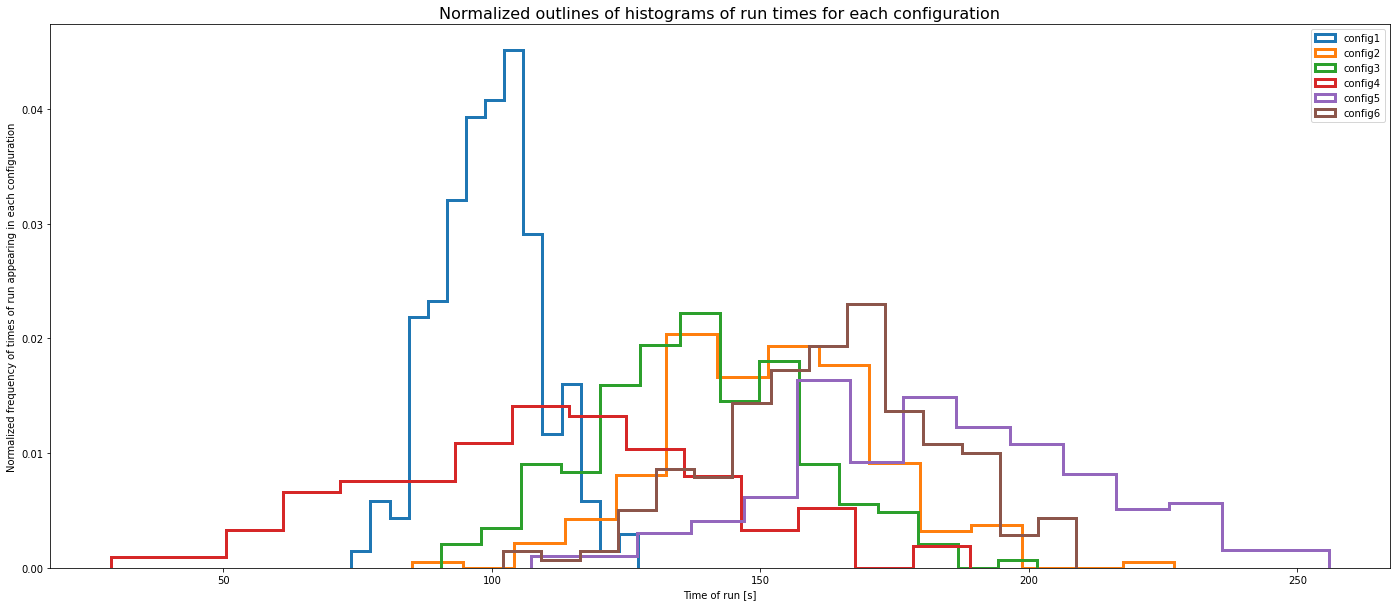

In [28]:
plt.figure(figsize=(24, 10))

grouped_df = df.groupby("conf")
for name, group in grouped_df:
    plt.hist(group["time"], bins=15, label=name, histtype="step", linewidth=3, density=True)

plt.title("Normalized outlines of histograms of run times for each configuration", fontsize=16)
plt.xlabel("Time of run [s]")
plt.ylabel("Normalized frequency of times of run appearing in each configuration")
plt.legend()

plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte výsledky z tabulky._ (komentuji vizualizaci)

Nechtěl jsem opakovat vizualizaci z 1. úkolu a proto jsem pro tento úkol zvolil překrývající se normalizované histogramy. Ačkoliv je tato vizualizace na první pohled poměrně nepřehledná, umožňuje zkoumat i jiné aspekty než zmíněný *box plot*. Zejména lze touto vizualizací získat velmi dobrou představu o hustotě rozdělení pravděpodobnosti pro jednotlivé konfigurace. Dále si lze, stejně jako u *box plot*, udělat dobrou představu o rozptylu hodnot jednotlivých konfigurací, ale navíc je také možné zkoumat špičatost a šikmost jednotlivých rozdělení. Naopak z histogramů lze oproti *box plot* hůře identifikovat deskriptivní parametry.

Jak už bylo dříve identifikováno, lze pozorovat, že všechna rozdělení téměř odpovídají Normálnímu rozdělení. Tzn., nejsou ani špičatá ani plochá a ani šikmá. Rozdělení s nejmenším rozptylem hodnot má konfigurace **config1** a naopak rozdělení délek běhů konfigurace **config4** má rozptyl největší. Tyto konfigurace jsou svou pozicí v grafu (nejblíže k ose y, tj. v průměru s nejmenšími naměřenými hodnotami) také vhodné pro následující důkladnější porovnání a určení té nejrychlejší konfigurace ze všech.

Zde je také vhodné zmínit poznámku, že optimální konfigurace algoritmu pro daný problém nemusí být vybrána jen na základě objektivního zkoumání. Např. pokud by se jednalo o algoritmy pro řazení a my věděli, že naše data budou nějak specifická, např. již částečně seřazená, může být vhodnější vybrat konfiguraci **config4** (řekněme *Bubble Sort*) a pohybovat se primárně v levé části jejího rozdělení oproti konfiguraci **config1** (řekněme *Quick Sort*), kde bychom se pohybovali v celém jejím rozdělení hodnot.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozdělení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozdělení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozdělení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Budu zkoumat (porovnávat) délky běhů konfigurací **config1** a **config4**, které jsou na základě analýzy deskriptivních parametrů a vizualizace zřejmě nejrychlejší. Rozdělení naměřených délek běhů obou konfigurací odpovídají Normálnímu rozdělení, jak už bylo zdůvodněno výše. Statistickým testováním se budu snažit dokázat, že je konfigurace **config1** v průměru rychlejší než konfigurace **config4**, tj. že střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config1**, je menší než střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config4**.

In [29]:
config1_mask = df["conf"] == "config1"
config4_mask = df["conf"] == "config4"

# Unbiased estimates of the mean and variance of the run times for each configuration
config1_mean_estimate = df.loc[config1_mask]["time"].mean()
config4_mean_estimate = df.loc[config4_mask]["time"].mean()

config1_variance_estimate = df.loc[config1_mask]["time"].var(ddof=1)
config4_variance_estimate = df.loc[config4_mask]["time"].var(ddof=1)

r = lambda x: round(x, 2)
(r(config1_mean_estimate), r(config1_variance_estimate), r(config4_mean_estimate), r(config4_variance_estimate))

(99.59, 88.11, 110.32, 939.84)

Nestranné odhady parametrů Normálních rozdělení délek běhů konfigurací jsou následující:
* $\hat{\mu}_{config1}=99.59$, $\hat{\sigma}^2_{config4}=88.11$
* $\hat{\mu}_{config1}=110.32$, $\hat{\sigma}^2_{config4}=939.84$

Z odhadů parametrů je zřejmé, že výběrové rozptyly se poměrně hodně liší. Jestli se rozptyly liší i statisticky významně ověřím Levenovým testem shody rozptylů, protože případná odlišnost rozptylů ovlivní výběr statistického testu pro porovnání středních hodnot. Nulovou hypotézu $H_0$ pro tento test tedy zvolím jako: *"Rozptyly jsou shodné."*. Alternativní hypotéza $H_1$ pak zní následovně: *"Rozptyly jsou různé."*.

In [30]:
# Levene's test for equality of variances
_, p_value_var = stats.levene(df.loc[config1_mask]["time"], df.loc[config4_mask]["time"])

print(f"p-value: {p_value_var}")
if p_value_var < 0.01:
    print("The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore the variances differ.")
else:
    print("Failed to reject the null hypothesis at a significance level of 0.01.")

p-value: 1.052092996722567e-28
The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore the variances differ.


Podařilo se mi zamítnout nulovou hypotézu $H_0$ na 1% hladině statistické významnosti, přijímám alternativní hypotézu $H_1$ a mohu tedy považovat rozptyly za různé. Současně je ze zadání jasné, že první běh algoritmu s konfigurací **config1** nikterak nesouvisí s prvním během algoritmu s konfigurací **config4** atd., čili neexistuje zde žádná párová závislost. Tzn., že pro porovnání středních hodnot použiji **Welchův t-test**. 

Pro Welchův t-test zvolím nulovou hypotézu $H_0$ jako: *"Střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config1**, je větší než střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config4**, nebo jsou tyto střední hodnoty rovny."*. Alternativní hypotéza $H_1$ pak zní následovně: *"Střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config1**, je menší než střední hodnota Normálního rozdělení, ze kterého pochází délky běhů konfigurace **config4**."*.

In [31]:
# Welch's t-test for relative difference of means (mean is the expected value for Normal distribution)
_, p_value_mean = stats.ttest_ind(df.loc[config1_mask]["time"], df.loc[config4_mask]["time"], equal_var=False, alternative="less")

print(f"p-value: {p_value_mean}")
if p_value_mean < 0.01:
    print("The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore",
          "the expected value of the first distribution is smaller than the expected value of the second distribution.", sep="\n")
else:
    print("Failed to reject the null hypothesis at a significance level of 0.01.")

p-value: 2.0843410569946737e-06
The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore
the expected value of the first distribution is smaller than the expected value of the second distribution.


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Závěrem statistického testu je zamítnutí nulové hypotézy $H_0$ na 1% hladině statistické významnosti, přijmutí alternativní hypotézy $H_1$ a potvrzení, že konfigurace **config1** algoritmu bude v průměru rychlejší než jeho konfigurace **config4** bez ohledu na vstupní hodnoty.

In [32]:
def my_welch_t_test(x: np.ndarray, y: np.ndarray, alternative: {"two-sided", "less", "greater"} = "two-sided") -> tuple:
    """
    Performs Welch's t-test.
    :param x: samples from the first distribution
    :param y: samples from the second distribution
    :param alternative: the alternative hypothesis, i.e. when p_value is small enough, this hypothesis is accepted, one of: "two-sided", "less", "greater"

    :return: tuple (t, p_value) where t is the t-statistic and p_value is the p-value of the test
    """

    x_mean = x.mean()
    y_mean = y.mean()
    x_var = x.var(ddof=1)
    y_var = y.var(ddof=1)
    n_x = len(x)
    n_y = len(y)

    # see: https://en.wikipedia.org/wiki/Welch%27s_t-test#Calculations
    t = (x_mean - y_mean) / np.sqrt(x_var / n_x + y_var / n_y)
    v = (x_var / n_x + y_var / n_y) ** 2 / (x_var ** 2 / (n_x ** 2 * (n_x - 1)) + y_var ** 2 / (n_y ** 2 * (n_y - 1)))

    if alternative == "two-sided":
        p_value = (1 - stats.t.cdf(np.abs(t), v)) * 2
    elif alternative == "less":
        p_value = stats.t.cdf(t, v)
    elif alternative == "greater":
        p_value = 1 - stats.t.cdf(t, v)
    else:
        raise ValueError("Invalid alternative provided. Use 'two-sided', 'less', or 'greater'.")

    return (t, p_value)


_, my_p_value_mean = my_welch_t_test(df.loc[config1_mask]["time"], df.loc[config4_mask]["time"], alternative="less")

print(f"p-value: {my_p_value_mean}")
if my_p_value_mean < 0.01:
    print("The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore",
          "the expected value of the first distribution is smaller than the expected value of the second distribution.", sep="\n")
else:
    print("Failed to reject the null hypothesis at a significance level of 0.01.")


####################### Verify that the results of my implementation are correct #######################
EPS = 1e-5
number_of_configs = len(df["conf"].unique())

for i in range(1, number_of_configs + 1):
    for j in range(1, number_of_configs + 1):
        my_t, my_p_value = my_welch_t_test(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"])
        t, p_value = stats.ttest_ind(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"], equal_var=False)
        assert np.abs(my_t - t) < EPS, f"two-sided - i: {i}, j: {j}, my_t: {my_t}, t: {t}"
        assert np.abs(my_p_value - p_value) < EPS, f"two-sided - i: {i}, j: {j}, my_p_value: {my_p_value}, p_value: {p_value}"

        my_t, my_p_value = my_welch_t_test(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"], alternative="less")
        t, p_value = stats.ttest_ind(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"], equal_var=False, alternative="less")
        assert np.abs(my_t - t) < EPS, f"less - i: {i}, j: {j}, my_t: {my_t}, t: {t}"
        assert np.abs(my_p_value - p_value) < EPS, f"less - i: {i}, j: {j}, my_p_value: {my_p_value}, p_value: {p_value}"

        my_t, my_p_value = my_welch_t_test(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"], alternative="greater")
        t, p_value = stats.ttest_ind(df.loc[df["conf"] == f"config{i}"]["time"], df.loc[df["conf"] == f"config{j}"]["time"], equal_var=False, alternative="greater")
        assert np.abs(my_t - t) < EPS, f"greater - i: {i}, j: {j}, my_t: {my_t}, t: {t}"
        assert np.abs(my_p_value - p_value) < EPS, f"greater - i: {i}, j: {j}, my_p_value: {my_p_value}, p_value: {p_value}"

p-value: 2.0843410569946813e-06
The null hypothesis is rejected at a significance level of 0.01, the alternative hypothesis is accepted, therefore
the expected value of the first distribution is smaller than the expected value of the second distribution.
